Creating sample room layout...
Running optimization algorithms...
Running Pelican...
 Run 1/75
POA early stopping at iteration 49
 Run 2/75
POA early stopping at iteration 75
 Run 3/75
POA early stopping at iteration 75
 Run 4/75
POA early stopping at iteration 50
 Run 5/75
POA early stopping at iteration 49
 Run 6/75
POA early stopping at iteration 72
 Run 7/75
POA early stopping at iteration 49
 Run 8/75
POA early stopping at iteration 49
 Run 9/75
POA early stopping at iteration 76
 Run 10/75
POA early stopping at iteration 49
 Run 11/75
POA early stopping at iteration 71
 Run 12/75
POA early stopping at iteration 49
 Run 13/75
POA early stopping at iteration 87
 Run 14/75
POA early stopping at iteration 62
 Run 15/75
POA early stopping at iteration 60
 Run 16/75
POA early stopping at iteration 62
 Run 17/75
POA early stopping at iteration 65
 Run 18/75
POA early stopping at iteration 55
 Run 19/75
 Run 20/75
POA early stopping at iteration 49
 Run 21/75
POA early stopping at iterat

C:\Users\gauth\AppData\Local\Temp\ipykernel_19156\2694604071.py:1592: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


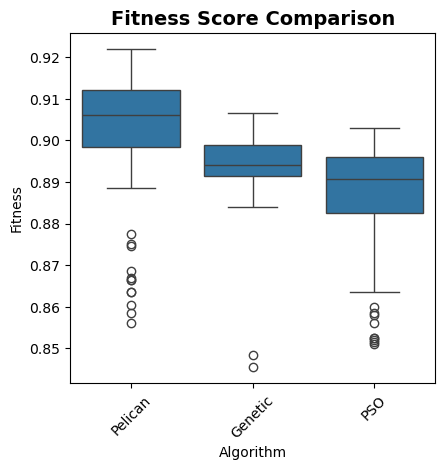

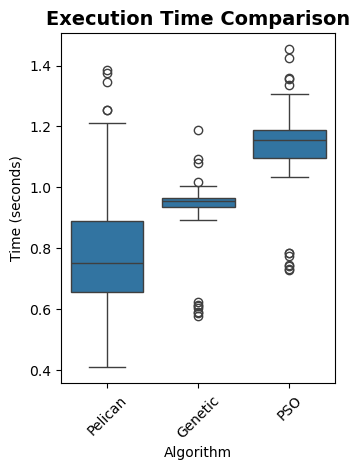

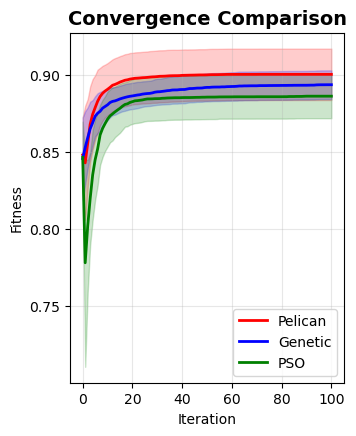

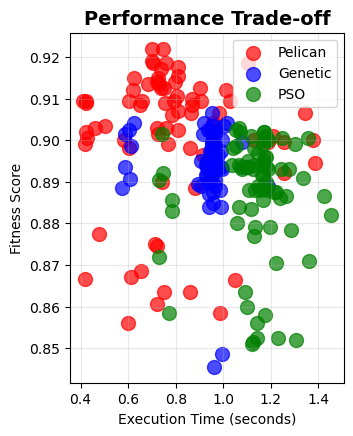

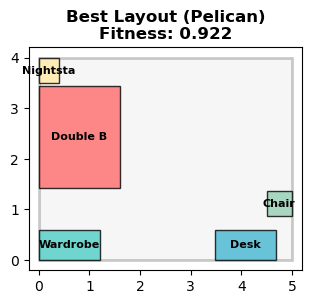

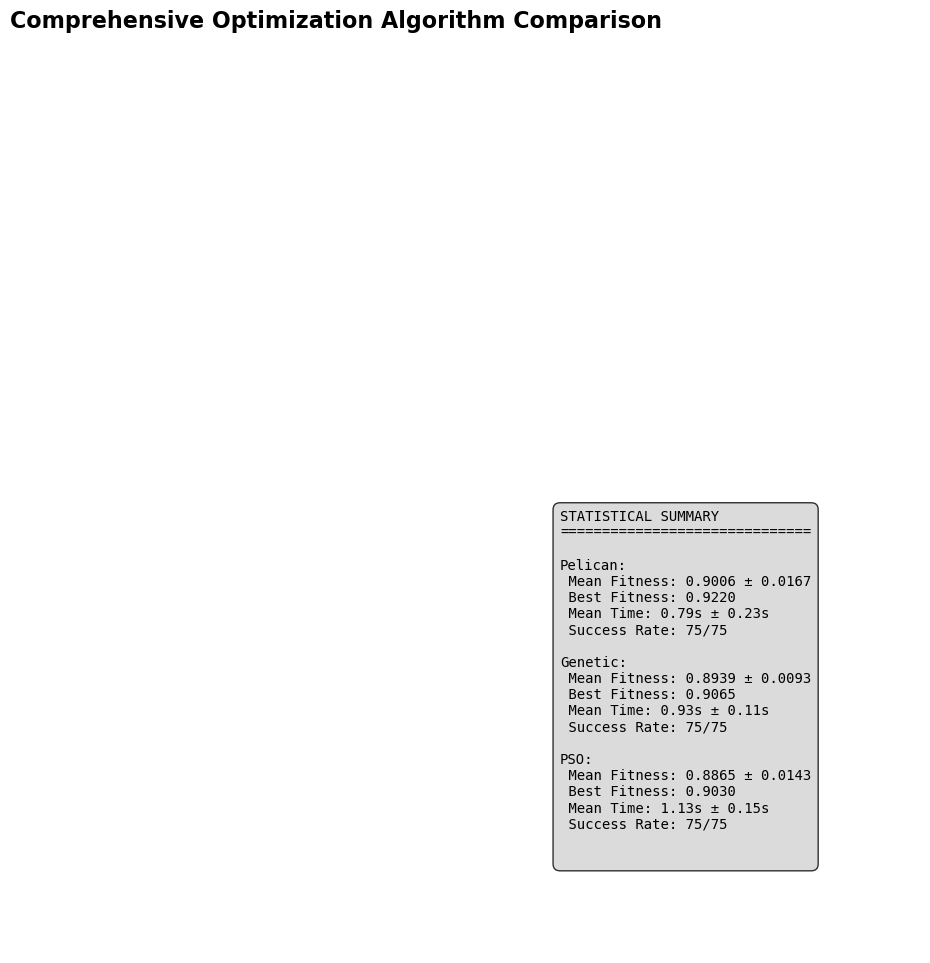

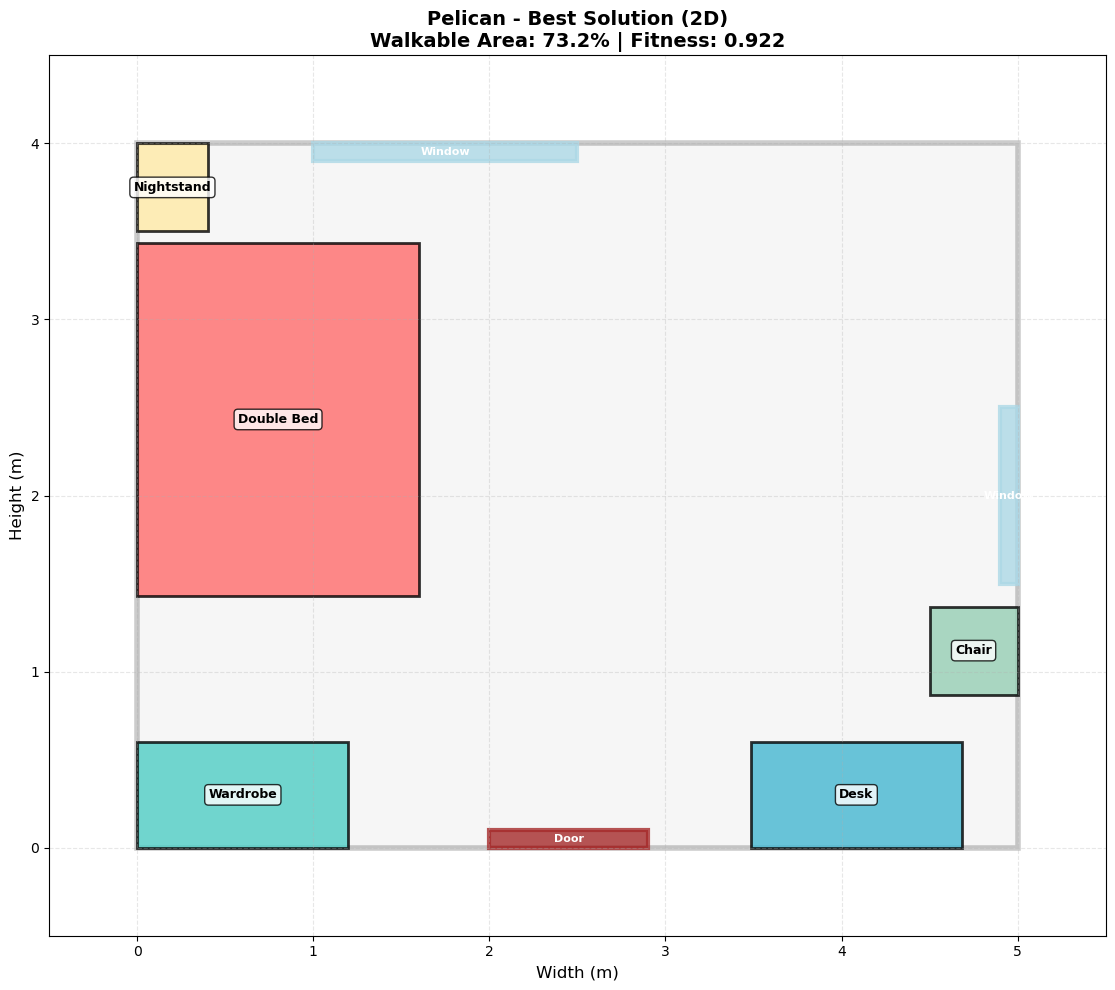

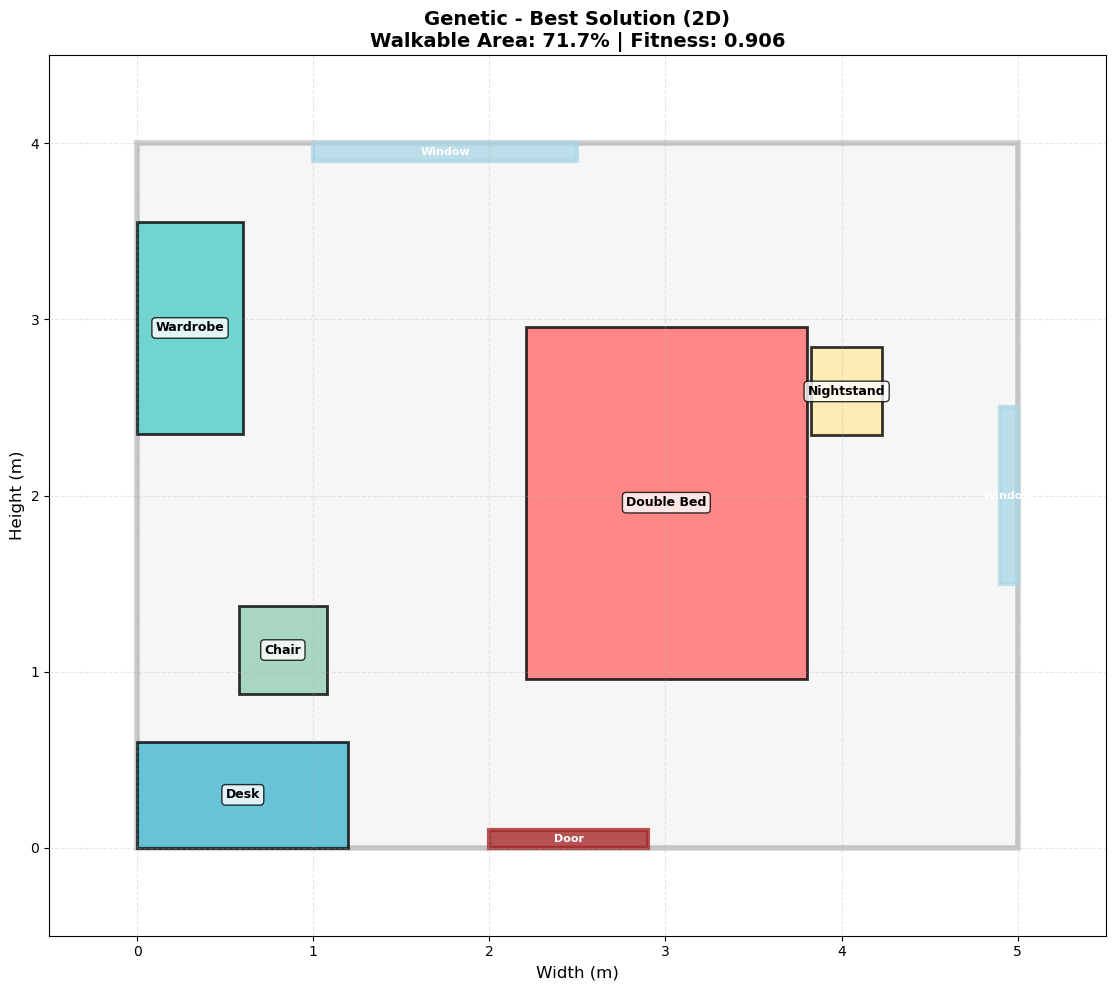

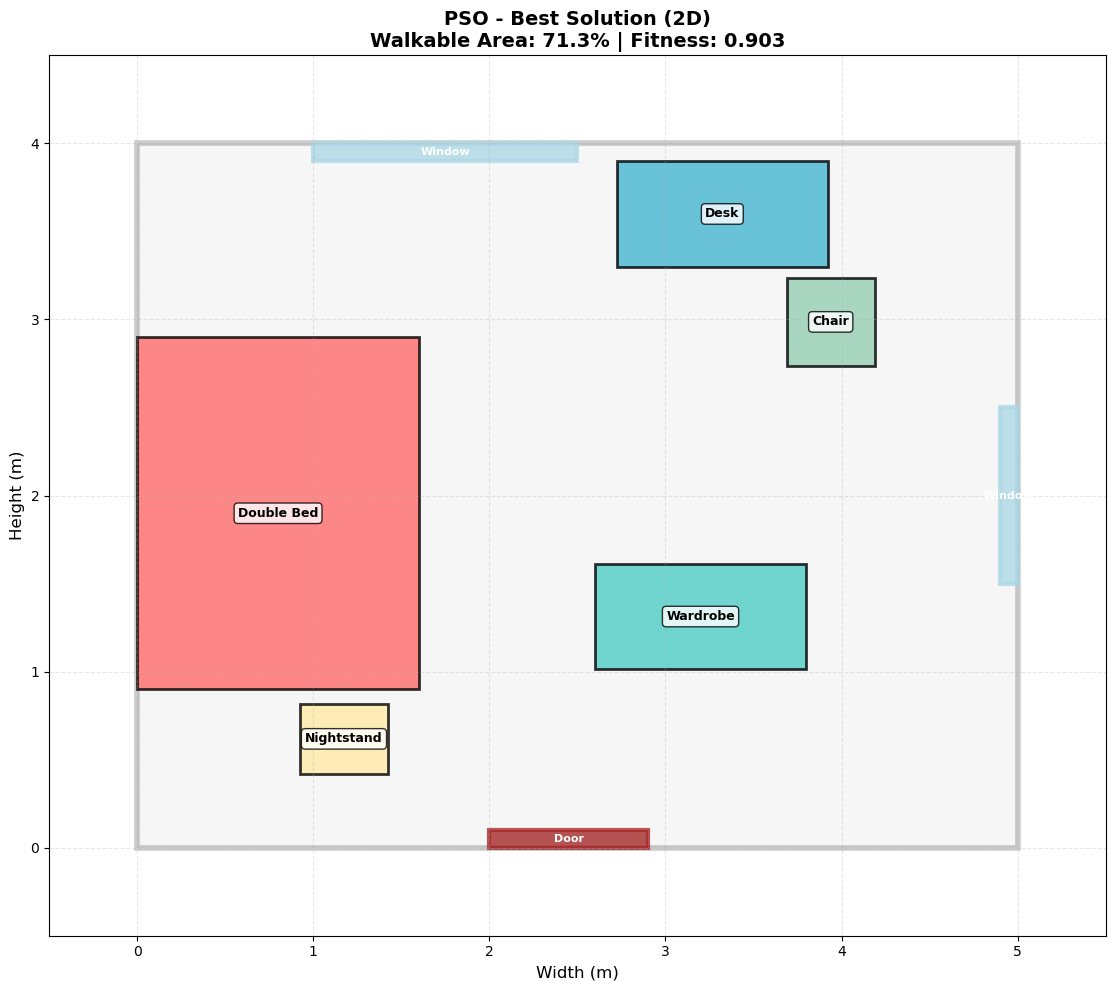

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any
from enum import Enum
import time
from abc import ABC, abstractmethod
import pandas as pd
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import json

class ObstacleType(Enum):
    FULL_BLOCKING = "full_blocking"
    PARTIAL_BLOCKING = "partial_blocking"

class WallFeatureType(Enum):
    DOOR = "door"
    WINDOW = "window"

@dataclass
class WallFeature:
    """Represents doors and windows on room walls"""
    name: str
    feature_type: WallFeatureType
    wall: str # 'north', 'south', 'east', 'west'
    position: float # Position along the wall (0 to wall_length)
    width: float
    height: float = 2.0 # Default height for doors/windows
    clearance_required: float = 0.8 # Minimum clearance needed in front

@dataclass
class Obstacle:
    """Represents a furniture item or obstacle in the room"""
    name: str
    width: float
    height: float
    obstacle_type: ObstacleType
    depth: float = 0.5 # Added depth for 3D visualization
    can_stack: bool = False
    stackable_on: List[str] = None
    min_wall_clearance: float = 0.1 # Minimum distance from walls
    preferred_wall_distance: float = 0.3 # Preferred distance from walls

    def __post_init__(self):
        if self.stackable_on is None:
            self.stackable_on = []

def set_random_seed(seed=42):
    """Set random seeds for all random number generators used"""
    random.seed(seed)
    np.random.seed(seed)
    # If you use other libraries with randomness, set their seeds here too

class Solution:
    """Base class for representing a furniture arrangement solution"""
    def __init__(self, obstacles: List[Obstacle], room_width: float, room_height: float,
             wall_features: List[WallFeature] = None):
      self.obstacles = obstacles
      self.room_width = room_width
      self.room_height = room_height
      self.wall_features = wall_features or []
      self.num_obstacles = len(obstacles)
      # Position: [x1, y1, rot1, x2, y2, rot2, ...]
      self.position = np.zeros(self.num_obstacles * 3)
      self.fitness = 0.0
      self.walkable_percentage = 0.0  # Initialize walkable percentage
      self._initialize_smart_positions()

    def _initialize_smart_positions(self):
        """Initialize positions with non-overlapping heuristic considering doors/windows"""
        placed_rects = []
        # Create exclusion zones around doors for clearance
        door_exclusion_zones = []
        for feature in self.wall_features:
            if feature.feature_type == WallFeatureType.DOOR:
                exclusion_zone = self._get_door_exclusion_zone(feature)
                door_exclusion_zones.append(exclusion_zone)

        for i in range(self.num_obstacles):
            obstacle = self.obstacles[i]
            attempts = 0
            max_attempts = 150
            while attempts < max_attempts:
                rotation = random.choice([0, 1, 2, 3]) # 0, 90, 180, 270 degrees
                if rotation in [1, 3]:
                    w, h = obstacle.height, obstacle.width
                else:
                    w, h = obstacle.width, obstacle.height

                # Ensure minimum clearance from walls
                x = random.uniform(obstacle.min_wall_clearance,
                                   max(obstacle.min_wall_clearance, self.room_width - w - obstacle.min_wall_clearance))
                y = random.uniform(obstacle.min_wall_clearance,
                                   max(obstacle.min_wall_clearance, self.room_height - h - obstacle.min_wall_clearance))

                new_rect = (x, y, x + w, y + h)

                # Check for overlaps with existing furniture
                overlap = False
                for rect in placed_rects:
                    if self._rectangles_overlap(new_rect, rect):
                        overlap = True
                        break

                # Check for conflicts with door exclusion zones
                if not overlap:
                    for exclusion_zone in door_exclusion_zones:
                        if self._rectangles_overlap(new_rect, exclusion_zone):
                            overlap = True
                            break

                if not overlap:
                    placed_rects.append(new_rect)
                    idx = i * 3
                    self.position[idx] = x
                    self.position[idx + 1] = y
                    self.position[idx + 2] = rotation
                    break

                attempts += 1

            if attempts >= max_attempts:
                # Fallback placement
                rotation = random.choice([0, 1, 2, 3])
                if rotation in [1, 3]:
                    w, h = obstacle.height, obstacle.width
                else:
                    w, h = obstacle.width, obstacle.height

                x = random.uniform(0, max(0.1, self.room_width - w))
                y = random.uniform(0, max(0.1, self.room_height - h))
                idx = i * 3
                self.position[idx] = x
                self.position[idx + 1] = y
                self.position[idx + 2] = rotation
    def _get_window_exclusion_zone(self, window: WallFeature) -> Tuple[float, float, float, float]:
      """Calculate exclusion zone in front of a window"""
      window_depth = 0.5  # How far the window exclusion zone extends into the room

      if window.wall == 'north': # Top wall
          return (window.position, self.room_height - window_depth,
                  window.position + window.width, self.room_height)
      elif window.wall == 'south': # Bottom wall
          return (window.position, 0,
                  window.position + window.width, window_depth)
      elif window.wall == 'east': # Right wall
          return (self.room_width - window_depth, window.position,
                  self.room_width, window.position + window.width)
      elif window.wall == 'west': # Left wall
          return (0, window.position,
                  window_depth, window.position + window.width)

    def _get_door_exclusion_zone(self, door: WallFeature) -> Tuple[float, float, float, float]:
        """Calculate exclusion zone in front of a door"""
        clearance = door.clearance_required
        if door.wall == 'north': # Top wall
            return (door.position - clearance/2, self.room_height - clearance,
                    door.position + door.width + clearance/2, self.room_height)
        elif door.wall == 'south': # Bottom wall
            return (door.position - clearance/2, 0,
                    door.position + door.width + clearance/2, clearance)
        elif door.wall == 'east': # Right wall
            return (self.room_width - clearance, door.position - clearance/2,
                    self.room_width, door.position + door.width + clearance/2)
        elif door.wall == 'west': # Left wall
            return (0, door.position - clearance/2,
                    clearance, door.position + door.width + clearance/2)

    def _rectangles_overlap(self, rect1, rect2):
        """Check if two rectangles overlap"""
        x1_min, y1_min, x1_max, y1_max = rect1
        x2_min, y2_min, x2_max, y2_max = rect2
        return not (x1_max <= x2_min or x2_max <= x1_min or
                    y1_max <= y2_min or y2_max <= y1_min)

    def get_obstacle_positions(self) -> List[Tuple[float, float, int]]:
        """Extract obstacle positions and rotations from solution"""
        positions = []
        for i in range(0, len(self.position), 3):
            x = self.position[i]
            y = self.position[i + 1]
            rotation = int(self.position[i + 2]) % 4 * 90
            positions.append((x, y, rotation))
        return positions

    def calculate_fitness(self) -> float:
      """Enhanced fitness calculation with furniture arrangement constraints"""
      positions = self.get_obstacle_positions()
      grid_size = 0.1
      grid_width = int(np.ceil(self.room_width / grid_size))
      grid_height = int(np.ceil(self.room_height / grid_size))
      occupancy_grid = np.zeros((grid_height, grid_width))

      penalty = 0.0
      rectangles = []

      # Process furniture positions
      for i, (x, y, rotation) in enumerate(positions):
          obstacle = self.obstacles[i]
          if rotation in [90, 270]:
              w, h = obstacle.height, obstacle.width
          else:
              w, h = obstacle.width, obstacle.height

          # Boundary penalties
          if x < 0 or y < 0 or x + w > self.room_width or y + h > self.room_height:
              penalty += 10.0
              x = max(0, min(x, self.room_width - w))
              y = max(0, min(y, self.room_height - h))

          rectangles.append((x, y, x + w, y + h, obstacle.obstacle_type, obstacle.name))

      # Check for overlaps
      for i in range(len(rectangles)):
          if rectangles[i][4] == ObstacleType.FULL_BLOCKING:
              for j in range(i + 1, len(rectangles)):
                  if rectangles[j][4] == ObstacleType.FULL_BLOCKING:
                      if self._rectangles_overlap(rectangles[i][:4], rectangles[j][:4]):
                          overlap_area = self._calculate_overlap_area(rectangles[i][:4], rectangles[j][:4])
                          penalty += overlap_area * 50.0

      # Door clearance penalties
      for feature in self.wall_features:
          if feature.feature_type == WallFeatureType.DOOR:
              exclusion_zone = self._get_door_exclusion_zone(feature)
              for rect in rectangles:
                  if rect[4] == ObstacleType.FULL_BLOCKING:
                      if self._rectangles_overlap(rect[:4], exclusion_zone):
                          overlap_area = self._calculate_overlap_area(rect[:4], exclusion_zone)
                          penalty += overlap_area * 30.0 # Door blocking penalty

      # NEW: Window obstruction penalties - nothing should block windows
      for feature in self.wall_features:
          if feature.feature_type == WallFeatureType.WINDOW:
              exclusion_zone = self._get_window_exclusion_zone(feature)
              for rect in rectangles:
                  if rect[4] == ObstacleType.FULL_BLOCKING:
                      if self._rectangles_overlap(rect[:4], exclusion_zone):
                          overlap_area = self._calculate_overlap_area(rect[:4], exclusion_zone)
                          penalty += overlap_area * 40.0  # Window blocking penalty (higher than door)

      # Mark occupied areas
      for x, y, x_max, y_max, obs_type, _ in rectangles:
          if obs_type == ObstacleType.FULL_BLOCKING:
              x_start = max(0, int(x / grid_size))
              y_start = max(0, int(y / grid_size))
              x_end = min(grid_width, int(np.ceil(x_max / grid_size)))
              y_end = min(grid_height, int(np.ceil(y_max / grid_size)))
              occupancy_grid[y_start:y_end, x_start:x_end] = 1

      walkable_cells = np.sum(occupancy_grid == 0)
      total_cells = grid_width * grid_height
      walkable_percentage = walkable_cells / total_cells if total_cells > 0 else 0

      # Store the actual walkable percentage for visualization
      self.walkable_percentage = walkable_percentage

      # Spacing bonus
      spacing_bonus = self._calculate_spacing_bonus(rectangles)

      # Wall alignment bonus for wardrobes and other large furniture
      wall_alignment_bonus = self._calculate_wall_alignment(rectangles)

      # Furniture relationship bonus (sofa facing TV, chairs with tables)
      furniture_relationship_bonus = self._calculate_furniture_relationships(rectangles)

      # Calculate final fitness
      fitness = walkable_percentage + spacing_bonus + wall_alignment_bonus + furniture_relationship_bonus - penalty / 100.0

      return max(0, fitness)

    def _calculate_wall_alignment(self, rectangles):
      """Calculate bonus for furniture properly aligned with walls"""
      bonus = 0.0
      wall_threshold = 0.2  # Distance threshold to consider furniture aligned with wall

      for x, y, x_max, y_max, obs_type, name in rectangles:
          # Check if furniture is a wardrobe, bookshelf, cabinet or other wall-aligned furniture
          name_lower = name.lower()
          if ("wardrobe" in name_lower or "bookshelf" in name_lower or
              "cabinet" in name_lower or "desk" in name_lower):

              # Check alignment with walls
              if (x <= wall_threshold or  # Left wall
                  y <= wall_threshold or  # Bottom wall
                  abs(x_max - self.room_width) <= wall_threshold or  # Right wall
                  abs(y_max - self.room_height) <= wall_threshold):  # Top wall

                  bonus += 0.05  # Bonus for proper wall alignment
              else:
                  bonus -= 0.02  # Small penalty for wardrobes not against walls

          return bonus

    def _calculate_furniture_relationships(self, rectangles):
      """Calculate bonus for good furniture relationships"""
      bonus = 0.0

      # Find specific furniture types
      sofas = []
      tvs = []
      chairs = []
      tables_and_desks = []  # Combined category for both tables and desks
      beds = []
      nightstands = []
      coffee_tables = []  # NEW: Added coffee tables

      for i, (x, y, x_max, y_max, obs_type, name) in enumerate(rectangles):
          name_lower = name.lower()
          if "sofa" in name_lower or "couch" in name_lower:
              sofas.append((i, x, y, x_max, y_max))
          elif "tv" in name_lower or "television" in name_lower:
              tvs.append((i, x, y, x_max, y_max))
          elif "chair" in name_lower:
              chairs.append((i, x, y, x_max, y_max))
          # Group tables and desks together for chair association
          elif ("table" in name_lower or "dining" in name_lower or "desk" in name_lower) and "coffee" not in name_lower:
              tables_and_desks.append((i, x, y, x_max, y_max))
          elif "coffee" in name_lower and "table" in name_lower:
              coffee_tables.append((i, x, y, x_max, y_max))
          elif "bed" in name_lower:
              beds.append((i, x, y, x_max, y_max))
          elif "nightstand" in name_lower:
              nightstands.append((i, x, y, x_max, y_max))

      # Check sofa facing TV and coffee table arrangement
      for sofa_i, sofa_x, sofa_y, sofa_x_max, sofa_y_max in sofas:
          sofa_center_x = (sofa_x + sofa_x_max) / 2
          sofa_center_y = (sofa_y + sofa_y_max) / 2
          sofa_rotation = int(self.position[sofa_i * 3 + 2]) % 4
          sofa_width = sofa_x_max - sofa_x
          sofa_height = sofa_y_max - sofa_y

          # Define the "front" of the sofa based on rotation
          sofa_front_x, sofa_front_y = sofa_center_x, sofa_center_y
          if sofa_rotation == 0:  # Facing up
              sofa_front_y = sofa_y_max
              front_direction = (0, 1)  # Up
          elif sofa_rotation == 1:  # Facing left
              sofa_front_x = sofa_x
              front_direction = (-1, 0)  # Left
          elif sofa_rotation == 2:  # Facing down
              sofa_front_y = sofa_y
              front_direction = (0, -1)  # Down
          else:  # Facing right
              sofa_front_x = sofa_x_max
              front_direction = (1, 0)  # Right

          # Check for coffee tables in front of the sofa
          has_coffee_table = False
          coffee_table_position = None

          for ct_idx, ct_x, ct_y, ct_x_max, ct_y_max in coffee_tables:
              ct_center_x = (ct_x + ct_x_max) / 2
              ct_center_y = (ct_y + ct_y_max) / 2

              # Vector from sofa front to coffee table
              dx = ct_center_x - sofa_front_x
              dy = ct_center_y - sofa_front_y

              # Distance from sofa front to coffee table
              distance = np.sqrt(dx**2 + dy**2)

              # Dot product to check if coffee table is in front of sofa
              dot_product = dx * front_direction[0] + dy * front_direction[1]

              # Coffee table should be in front of sofa (dot product > 0) and within reasonable distance
              if dot_product > 0 and 0.2 < distance < 1.5:
                  # Check if coffee table is roughly centered with the sofa
                  if sofa_rotation in [0, 2]:  # Sofa facing up/down
                      if abs(ct_center_x - sofa_center_x) < sofa_width * 0.6:
                          has_coffee_table = True
                          coffee_table_position = (ct_center_x, ct_center_y)
                          bonus += 0.08  # Bonus for coffee table in front of sofa
                  else:  # Sofa facing left/right
                      if abs(ct_center_y - sofa_center_y) < sofa_height * 0.6:
                          has_coffee_table = True
                          coffee_table_position = (ct_center_x, ct_center_y)
                          bonus += 0.08  # Bonus for coffee table in front of sofa

          # Penalize sofa without coffee table if there are coffee tables in the room
          if not has_coffee_table and len(coffee_tables) > 0:
              bonus -= 0.05  # Penalty for sofa without coffee table

          # Check TV-sofa-coffee table arrangement
          for _, tv_x, tv_y, tv_x_max, tv_y_max in tvs:
              tv_center_x = (tv_x + tv_x_max) / 2
              tv_center_y = (tv_y + tv_y_max) / 2

              # Vector from sofa to TV
              dx_tv = tv_center_x - sofa_center_x
              dy_tv = tv_center_y - sofa_center_y
              tv_distance = np.sqrt(dx_tv**2 + dy_tv**2)

              # Check if sofa is facing TV (simplified check)
              is_facing = False
              if ((sofa_rotation == 0 and dy_tv > 0) or  # Sofa faces up
                  (sofa_rotation == 1 and dx_tv < 0) or  # Sofa faces left
                  (sofa_rotation == 2 and dy_tv < 0) or  # Sofa faces down
                  (sofa_rotation == 3 and dx_tv > 0)):   # Sofa faces right
                  is_facing = True
                  bonus += 0.05  # Bonus for sofa facing TV

              # Check TV-sofa-coffee table spacing
              if is_facing and has_coffee_table and 1.0 < tv_distance < 4.0:
                  # Vector from coffee table to TV
                  dx_ct_tv = tv_center_x - coffee_table_position[0]
                  dy_ct_tv = tv_center_y - coffee_table_position[1]
                  ct_tv_distance = np.sqrt(dx_ct_tv**2 + dy_ct_tv**2)

                  # Vector from sofa to coffee table
                  dx_sofa_ct = coffee_table_position[0] - sofa_center_x
                  dy_sofa_ct = coffee_table_position[1] - sofa_center_y
                  sofa_ct_distance = np.sqrt(dx_sofa_ct**2 + dy_sofa_ct**2)

                  # Ideal arrangement: coffee table between sofa and TV, closer to sofa
                  if sofa_ct_distance < ct_tv_distance and ct_tv_distance < tv_distance:
                      bonus += 0.07  # Ideal TV-sofa-coffee table arrangement

      # Check chairs with tables/desks and penalize isolated chairs
      chair_has_surface = [False] * len(chairs)  # Track which chairs are associated with tables/desks

      for chair_idx, (chair_i, chair_x, chair_y, chair_x_max, chair_y_max) in enumerate(chairs):
          chair_center_x = (chair_x + chair_x_max) / 2
          chair_center_y = (chair_y + chair_y_max) / 2
          chair_rotation = int(self.position[chair_i * 3 + 2]) % 4

          # Check against all tables AND desks
          for _, surface_x, surface_y, surface_x_max, surface_y_max in tables_and_desks:
              surface_center_x = (surface_x + surface_x_max) / 2
              surface_center_y = (surface_y + surface_y_max) / 2

              # Check if chair is near a table or desk
              dx = surface_center_x - chair_center_x
              dy = surface_center_y - chair_center_y
              distance = np.sqrt(dx**2 + dy**2)

              # Chair should be near table/desk but not overlapping
              if 0.1 < distance < 1.2:
                  chair_has_surface[chair_idx] = True  # Mark this chair as associated with a table/desk

                  # Check if chair is facing the table/desk
                  if ((chair_rotation == 0 and dy > 0) or  # Chair faces up
                      (chair_rotation == 1 and dx < 0) or  # Chair faces left
                      (chair_rotation == 2 and dy < 0) or  # Chair faces down
                      (chair_rotation == 3 and dx > 0)):   # Chair faces right
                      bonus += 0.05
                  else:
                      bonus += 0.02  # Still a small bonus for nearby chair, but better if facing

      # Apply penalty for chairs not associated with any table or desk
      for chair_idx, has_surface in enumerate(chair_has_surface):
          if not has_surface:
              # Significant penalty for isolated chairs
              bonus -= 0.15

      # Check nightstands placement relative to bed
      for _, bed_x, bed_y, bed_x_max, bed_y_max in beds:
          bed_width = bed_x_max - bed_x
          bed_height = bed_y_max - bed_y

          for _, ns_x, ns_y, ns_x_max, ns_y_max in nightstands:
              ns_center_x = (ns_x + ns_x_max) / 2
              ns_center_y = (ns_y + ns_y_max) / 2

              # Check if nightstand is near the side of the bed
              # Check left and right sides of the bed
              if ((abs(ns_center_y - (bed_y + bed_height/2)) < bed_height/2) and
                  (abs(ns_x - bed_x_max) < 0.3 or abs(ns_x_max - bed_x) < 0.3)):
                  bonus += 0.05
              # Check top and bottom sides of the bed
              elif ((abs(ns_center_x - (bed_x + bed_width/2)) < bed_width/2) and
                    (abs(ns_y - bed_y_max) < 0.3 or abs(ns_y_max - bed_y) < 0.3)):
                  bonus += 0.05

      return bonus

    def _calculate_overlap_area(self, rect1, rect2):
        """Calculate the area of overlap between two rectangles"""
        x1_min, y1_min, x1_max, y1_max = rect1
        x2_min, y2_min, x2_max, y2_max = rect2
        overlap_x = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
        overlap_y = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
        return overlap_x * overlap_y

    def _calculate_spacing_bonus(self, rectangles):
        """Calculate bonus for maintaining good spacing between furniture"""
        bonus = 0.0
        min_spacing = 0.6
        full_blocking_rects = [r for r in rectangles if r[4] == ObstacleType.FULL_BLOCKING]
        for i in range(len(full_blocking_rects)):
            for j in range(i + 1, len(full_blocking_rects)):
                distance = self._min_distance_between_rects(
                    full_blocking_rects[i][:4], full_blocking_rects[j][:4])
                if distance >= min_spacing:
                    bonus += 0.01
                elif distance > 0:
                    bonus += 0.005
        return bonus

    def _min_distance_between_rects(self, rect1, rect2):
        """Calculate minimum distance between two rectangles"""
        x1_min, y1_min, x1_max, y1_max = rect1
        x2_min, y2_min, x2_max, y2_max = rect2
        if self._rectangles_overlap(rect1, rect2):
            return 0
        dx = max(0, max(x1_min - x2_max, x2_min - x1_max))
        dy = max(0, max(y1_min - y2_max, y2_min - y1_max))
        return np.sqrt(dx**2 + dy**2)

    def visualize_solution_2d(self, position=None, title=None):
      """Enhanced 2D visualization with doors and windows"""
      if position is None:
          position = self.position
      if title is None:
          title = f"Room Layout (2D View)"
      fig, ax = plt.subplots(1, 1, figsize=(12, 10))

      # Draw room
      room_rect = patches.Rectangle((0, 0), self.room_width, self.room_height,
                                    linewidth=4, edgecolor='black', facecolor='lightgray', alpha=0.2)
      ax.add_patch(room_rect)

      # Draw doors and windows
      for feature in self.wall_features:
          self._draw_wall_feature(ax, feature)

      # Draw furniture and calculate walkable area
      positions = []
      for i in range(0, len(position), 3):
          x = position[i]
          y = position[i + 1]
          rotation = int(position[i + 2]) % 4 * 90
          positions.append((x, y, rotation))

      # Calculate walkable area directly
      grid_size = 0.1
      grid_width = int(np.ceil(self.room_width / grid_size))
      grid_height = int(np.ceil(self.room_height / grid_size))
      occupancy_grid = np.zeros((grid_height, grid_width))

      # Mark occupied areas
      for i, (x, y, rotation) in enumerate(positions):
          obstacle = self.obstacles[i]
          if rotation in [90, 270]:
              w, h = obstacle.height, obstacle.width
          else:
              w, h = obstacle.width, obstacle.height

          if obstacle.obstacle_type == ObstacleType.FULL_BLOCKING:
              x_start = max(0, int(x / grid_size))
              y_start = max(0, int(y / grid_size))
              x_end = min(grid_width, int(np.ceil((x + w) / grid_size)))
              y_end = min(grid_height, int(np.ceil((y + h) / grid_size)))
              occupancy_grid[y_start:y_end, x_start:x_end] = 1

      walkable_cells = np.sum(occupancy_grid == 0)
      total_cells = grid_width * grid_height
      walkable_pct = (walkable_cells / total_cells if total_cells > 0 else 0) * 100

      # Draw furniture
      colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F39C12', '#E74C3C']
      for i, (x, y, rotation) in enumerate(positions):
          obstacle = self.obstacles[i]
          if rotation in [90, 270]:
              w, h = obstacle.height, obstacle.width
          else:
              w, h = obstacle.width, obstacle.height

          color = colors[i % len(colors)]
          if obstacle.obstacle_type == ObstacleType.FULL_BLOCKING:
              facecolor = color
              alpha = 0.8
              edgecolor = 'black'
              linewidth = 2
          else:
              facecolor = 'none'
              alpha = 0.9
              edgecolor = color
              linewidth = 3

          rect = patches.Rectangle((x, y), w, h, linewidth=linewidth,
                                   edgecolor=edgecolor, facecolor=facecolor,
                                   alpha=alpha)
          ax.add_patch(rect)

          # Add furniture label
          ax.text(x + w/2, y + h/2, obstacle.name,
                  ha='center', va='center', fontsize=9, weight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

      ax.set_xlim(-0.5, self.room_width + 0.5)
      ax.set_ylim(-0.5, self.room_height + 0.5)
      ax.set_aspect('equal')
      ax.grid(True, alpha=0.3, linestyle='--')
      ax.set_xlabel('Width (m)', fontsize=12)
      ax.set_ylabel('Height (m)', fontsize=12)

      # Display calculated walkable percentage and fitness
      fitness_value = self.fitness
      ax.set_title(f'{title}\nWalkable Area: {walkable_pct:.1f}% | Fitness: {fitness_value:.3f}',
                  fontsize=14, fontweight='bold')
      plt.tight_layout()
      return fig, ax

    def visualize_solution_3d_plotly(self, position=None, title=None, wall_height=2.5):
      """Create an interactive 3D visualization using Plotly"""
      if position is None:
          position = self.position
      if title is None:
          title = f"Room Layout (3D View)"

      # Create figure
      fig = go.Figure()

      # Draw room floor
      fig.add_trace(go.Mesh3d(
          x=[0, 0, self.room_width, self.room_width],
          y=[0, self.room_height, self.room_height, 0],
          z=[0, 0, 0, 0],
          i=[0, 0],
          j=[1, 2],
          k=[2, 3],
          opacity=0.3,
          color='lightgray',
          name='Floor'
      ))

      # Draw walls
      # South wall
      fig.add_trace(go.Mesh3d(
          x=[0, 0, self.room_width, self.room_width],
          y=[0, 0, 0, 0],
          z=[0, wall_height, wall_height, 0],
          i=[0, 0],
          j=[1, 2],
          k=[2, 3],
          opacity=0.2,
          color='lightblue',
          name='South Wall'
      ))

      # East wall
      fig.add_trace(go.Mesh3d(
          x=[self.room_width, self.room_width, self.room_width, self.room_width],
          y=[0, self.room_height, self.room_height, 0],
          z=[0, 0, wall_height, wall_height],
          i=[0, 0],
          j=[1, 2],
          k=[2, 3],
          opacity=0.2,
          color='lightgreen',
          name='East Wall'
      ))

      # North wall
      fig.add_trace(go.Mesh3d(
          x=[0, 0, self.room_width, self.room_width],
          y=[self.room_height, self.room_height, self.room_height, self.room_height],
          z=[0, wall_height, wall_height, 0],
          i=[0, 0],
          j=[1, 2],
          k=[2, 3],
          opacity=0.2,
          color='lightblue',
          name='North Wall'
      ))

      # West wall
      fig.add_trace(go.Mesh3d(
          x=[0, 0, 0, 0],
          y=[0, self.room_height, self.room_height, 0],
          z=[0, 0, wall_height, wall_height],
          i=[0, 0],
          j=[1, 2],
          k=[2, 3],
          opacity=0.2,
          color='lightgreen',
          name='West Wall'
      ))

      # Draw doors and windows
      for feature in self.wall_features:
          door_height = feature.height
          window_height = feature.height
          window_bottom = 1.0  # Height from floor to bottom of window

          if feature.feature_type == WallFeatureType.DOOR:
              color = 'brown'
              z_start = 0  # Door starts at floor
              z_height = door_height
              name = f"Door: {feature.name}"
          else:  # Window
              color = 'skyblue'
              z_start = window_bottom
              z_height = window_height
              name = f"Window: {feature.name}"

          if feature.wall == 'north':  # Top wall
              x = [feature.position, feature.position + feature.width, feature.position + feature.width, feature.position]
              y = [self.room_height, self.room_height, self.room_height, self.room_height]
              z = [z_start, z_start, z_start + z_height, z_start + z_height]
              i = [0, 0]
              j = [1, 2]
              k = [2, 3]
          elif feature.wall == 'south':  # Bottom wall
              x = [feature.position, feature.position + feature.width, feature.position + feature.width, feature.position]
              y = [0, 0, 0, 0]
              z = [z_start, z_start, z_start + z_height, z_start + z_height]
              i = [0, 0]
              j = [1, 2]
              k = [2, 3]
          elif feature.wall == 'east':  # Right wall
              x = [self.room_width, self.room_width, self.room_width, self.room_width]
              y = [feature.position, feature.position + feature.width, feature.position + feature.width, feature.position]
              z = [z_start, z_start, z_start + z_height, z_start + z_height]
              i = [0, 0]
              j = [1, 2]
              k = [2, 3]
          elif feature.wall == 'west':  # Left wall
              x = [0, 0, 0, 0]
              y = [feature.position, feature.position + feature.width, feature.position + feature.width, feature.position]
              z = [z_start, z_start, z_start + z_height, z_start + z_height]
              i = [0, 0]
              j = [1, 2]
              k = [2, 3]

          fig.add_trace(go.Mesh3d(
              x=x, y=y, z=z,
              i=i, j=j, k=k,
              color=color,
              opacity=0.7,
              name=name
          ))

      # Draw furniture
      positions = []
      for i in range(0, len(position), 3):
          x = position[i]
          y = position[i + 1]
          rotation = int(position[i + 2]) % 4 * 90
          positions.append((x, y, rotation))

      colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F39C12', '#E74C3C']

      for i, (x, y, rotation) in enumerate(positions):
          obstacle = self.obstacles[i]
          if rotation in [90, 270]:
              w, h = obstacle.height, obstacle.width
          else:
              w, h = obstacle.width, obstacle.height

          # Use the depth from the obstacle if available, otherwise use default
          depth = obstacle.depth if hasattr(obstacle, 'depth') else 0.8

          color = colors[i % len(colors)]

          # Create furniture as a 3D box - for each face, define two triangles
          if rotation in [0, 180]:
              # Define all 8 vertices of the box
              vertices_x = [x, x+w, x+w, x, x, x+w, x+w, x]
              vertices_y = [y, y, y+h, y+h, y, y, y+h, y+h]
              vertices_z = [0, 0, 0, 0, depth, depth, depth, depth]

              # Define the 12 triangles (2 per face * 6 faces)
              # Bottom face
              i_indices = [0, 0]
              j_indices = [1, 2]
              k_indices = [2, 3]

              # Top face
              i_indices.extend([4, 4])
              j_indices.extend([5, 6])
              k_indices.extend([6, 7])

              # Side faces
              i_indices.extend([0, 0, 1, 1, 2, 2, 3, 3])
              j_indices.extend([1, 5, 2, 6, 3, 7, 0, 4])
              k_indices.extend([5, 4, 6, 5, 7, 6, 4, 7])

          else:  # Rotated 90 or 270 degrees
              # Define all 8 vertices of the box
              vertices_x = [x, x+h, x+h, x, x, x+h, x+h, x]
              vertices_y = [y, y, y+w, y+w, y, y, y+w, y+w]
              vertices_z = [0, 0, 0, 0, depth, depth, depth, depth]

              # Define the 12 triangles (2 per face * 6 faces)
              # Bottom face
              i_indices = [0, 0]
              j_indices = [1, 2]
              k_indices = [2, 3]

              # Top face
              i_indices.extend([4, 4])
              j_indices.extend([5, 6])
              k_indices.extend([6, 7])

              # Side faces
              i_indices.extend([0, 0, 1, 1, 2, 2, 3, 3])
              j_indices.extend([1, 5, 2, 6, 3, 7, 0, 4])
              k_indices.extend([5, 4, 6, 5, 7, 6, 4, 7])

          fig.add_trace(go.Mesh3d(
              x=vertices_x, y=vertices_y, z=vertices_z,
              i=i_indices, j=j_indices, k=k_indices,
              color=color,
              opacity=0.7,
              name=obstacle.name
          ))

          # Add furniture label
          if rotation in [0, 180]:
              label_x = x + w/2
              label_y = y + h/2
          else:
              label_x = x + h/2
              label_y = y + w/2
          label_z = depth + 0.1

          fig.add_trace(go.Scatter3d(
              x=[label_x], y=[label_y], z=[label_z],
              mode='text',
              text=[obstacle.name],
              textfont=dict(color='black', size=10),
              name=f"{obstacle.name} Label"
          ))

      # Update layout
      walkable_pct = self.walkable_percentage * 100 if hasattr(self, 'walkable_percentage') else 0
      fitness_value = self.fitness

      fig.update_layout(
          title=f'{title}<br>Walkable Area: {walkable_pct:.1f}% | Fitness: {fitness_value:.3f}',
          scene=dict(
              xaxis_title='X (width)',
              yaxis_title='Y (depth)',
              zaxis_title='Z (height)',
              aspectmode='data'
          ),
          scene_camera=dict(
              eye=dict(x=1.5, y=-1.5, z=1.0)
          ),
          margin=dict(l=0, r=0, b=0, t=50),
          height=800
      )

      return fig

    def _draw_wall_feature(self, ax, feature: WallFeature):
        """Draw doors and windows on the room walls"""
        if feature.wall == 'north': # Top wall
            x, y = feature.position, self.room_height
            width, height = feature.width, -0.1
        elif feature.wall == 'south': # Bottom wall
            x, y = feature.position, 0
            width, height = feature.width, 0.1
        elif feature.wall == 'east': # Right wall
            x, y = self.room_width, feature.position
            width, height = -0.1, feature.width
        elif feature.wall == 'west': # Left wall
            x, y = 0, feature.position
            width, height = 0.1, feature.width

        if feature.feature_type == WallFeatureType.DOOR:
            color = 'brown'
        else: # Window
            color = 'lightblue'

        rect = patches.Rectangle((x, y), width, height,
                                 linewidth=3, edgecolor=color, facecolor=color, alpha=0.8)
        ax.add_patch(rect)

        # Add label
        if feature.wall in ['north', 'south']:
            label_x, label_y = x + width/2, y + height/2
        else:
            label_x, label_y = x + width/2, y + height/2
        ax.text(label_x, label_y, feature.name, ha='center', va='center',
                fontsize=8, weight='bold', color='white')

    def copy(self):
        """Create a copy of the solution"""
        new_solution = Solution(self.obstacles, self.room_width, self.room_height, self.wall_features)
        new_solution.position = self.position.copy()
        new_solution.fitness = self.fitness
        return new_solution

# Optimization Algorithm Classes
class OptimizationAlgorithm(ABC):
    """Abstract base class for optimization algorithms"""
    def __init__(self, obstacles: List[Obstacle], room_width: float, room_height: float,
                 wall_features: List[WallFeature] = None, population_size: int = 50, max_iterations: int = 100, seed=42):
        # Store the seed
        self.seed = seed
        # Initialize with seed
        set_random_seed(self.seed)

        self.obstacles = obstacles
        self.room_width = room_width
        self.room_height = room_height
        self.wall_features = wall_features or []
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.best_solution = None
        self.fitness_history = []
        self.population_history = []

    @abstractmethod
    def optimize(self) -> Solution:
        """Run the optimization algorithm"""
        pass

    def create_random_solution(self) -> Solution:
        """Create a random solution"""
        return Solution(self.obstacles, self.room_width, self.room_height, self.wall_features)

class PelicanOptimizationAlgorithm(OptimizationAlgorithm):
    """Enhanced Pelican Optimization Algorithm implementation"""
    def optimize(self) -> Solution:
        """Run the Enhanced Pelican Optimization Algorithm"""
        # Initialize population
        population = [self.create_random_solution() for _ in range(self.population_size)]

        # Evaluate initial population
        for solution in population:
            solution.fitness = solution.calculate_fitness()

        # Track best solution
        self.best_solution = max(population, key=lambda x: x.fitness)
        self.fitness_history = [self.best_solution.fitness]
        self.population_history = [self.best_solution.copy()]

        for iteration in range(self.max_iterations):
            # Sort population by fitness
            population.sort(key=lambda x: x.fitness, reverse=True)

            for i in range(self.population_size):
                # Phase 1: Exploration (first half of population)
                if i < self.population_size // 2:
                    if i == 0:
                        # Best pelican does random walk
                        for j in range(len(population[i].position)):
                            if random.random() < 0.3: # 30% chance of modification
                                if j % 3 == 2: # Rotation parameter
                                    population[i].position[j] = random.randint(0, 3)
                                else: # Position parameters
                                    population[i].position[j] += np.random.normal(0, 0.1)
                    else:
                        # Move towards best pelican with exploration
                        best_pelican = population[0]
                        alpha = 2 * np.random.random() - 1 # Random coefficient [-1, 1]
                        for j in range(len(population[i].position)):
                            if j % 3 == 2: # Rotation parameter
                                if random.random() < 0.3:
                                    population[i].position[j] = best_pelican.position[j]
                                else:
                                    population[i].position[j] = random.randint(0, 3)
                            else: # Position parameters
                                population[i].position[j] = ((population[i].position[j] +
                                                            best_pelican.position[j]) / 2 +
                                                            alpha * np.random.random() * 0.5)
                # Phase 2: Exploitation (second half of population)
                else:
                    # Adaptive exploitation parameter
                    beta = 2 * (1 - iteration / self.max_iterations)
                    for j in range(len(population[i].position)):
                        r1, r2 = np.random.random(), np.random.random()
                        if j % 3 == 2: # Rotation parameter
                            if random.random() < beta:
                                population[i].position[j] = self.best_solution.position[j]
                            else:
                                population[i].position[j] = random.randint(0, 3)
                        else: # Position parameters
                            population[i].position[j] = (self.best_solution.position[j] +
                                                      beta * r1 * (self.best_solution.position[j] - population[i].position[j]) +
                                                      (1 - beta) * r2 * (np.random.random() - 0.5) * 0.3)

                # Apply constraints
                self._apply_constraints(population[i])

                # Evaluate fitness
                population[i].fitness = population[i].calculate_fitness()

                # Update global best
                if population[i].fitness > self.best_solution.fitness:
                    self.best_solution = population[i].copy()

            self.fitness_history.append(self.best_solution.fitness)
            self.population_history.append(self.best_solution.copy())

            # Relaxed early stopping condition
            if len(self.fitness_history) > 50:
                recent_improvements = [abs(self.fitness_history[i] - self.fitness_history[i-1]) for i in range(-30, 0)]
                if all(imp < 1e-5 for imp in recent_improvements):
                    print(f"POA early stopping at iteration {iteration}")
                    break

        return self.best_solution

    def _apply_constraints(self, solution):
        """Apply position constraints"""
        for i in range(0, len(solution.position), 3):
            obstacle_idx = i // 3
            if obstacle_idx < len(self.obstacles):
                obstacle = self.obstacles[obstacle_idx]
                rotation = int(solution.position[i + 2]) % 4
                if rotation in [1, 3]:
                    w_furniture, h_furniture = obstacle.height, obstacle.width
                else:
                    w_furniture, h_furniture = obstacle.width, obstacle.height

                solution.position[i] = np.clip(solution.position[i], 0, self.room_width - w_furniture)
                solution.position[i + 1] = np.clip(solution.position[i + 1], 0, self.room_height - h_furniture)
                solution.position[i + 2] = np.clip(solution.position[i + 2], 0, 3.99)

class GeneticAlgorithm(OptimizationAlgorithm):
    """Genetic Algorithm implementation for comparison"""
    def __init__(self, obstacles: List[Obstacle], room_width: float, room_height: float,
                 wall_features: List[WallFeature] = None, population_size: int = 50, max_iterations: int = 100,
                 mutation_rate: float = 0.15, crossover_rate: float = 0.8):
        super().__init__(obstacles, room_width, room_height, wall_features, population_size, max_iterations)
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

    def optimize(self) -> Solution:
        """Run the Genetic Algorithm"""
        # Initialize population
        population = [self.create_random_solution() for _ in range(self.population_size)]

        # Evaluate initial population
        for solution in population:
            solution.fitness = solution.calculate_fitness()

        # Track best solution
        self.best_solution = max(population, key=lambda x: x.fitness)
        self.fitness_history = [self.best_solution.fitness]
        self.population_history = [self.best_solution.copy()]

        for iteration in range(self.max_iterations):
            new_population = []

            # Elitism: Keep best solutions
            population.sort(key=lambda x: x.fitness, reverse=True)
            elite_count = max(2, self.population_size // 10)
            new_population.extend([p.copy() for p in population[:elite_count]])

            # Generate offspring
            while len(new_population) < self.population_size:
                # Selection
                parent1 = self._tournament_selection(population)
                parent2 = self._tournament_selection(population)

                # Crossover
                if random.random() < self.crossover_rate:
                    child1, child2 = self._crossover(parent1, parent2)
                else:
                    child1, child2 = parent1.copy(), parent2.copy()

                # Mutation
                if random.random() < self.mutation_rate:
                    self._mutate(child1)
                if random.random() < self.mutation_rate:
                    self._mutate(child2)

                new_population.extend([child1, child2])

            # Trim population to exact size
            population = new_population[:self.population_size]

            # Evaluate population
            for solution in population:
                solution.fitness = solution.calculate_fitness()

            # Update best solution
            current_best = max(population, key=lambda x: x.fitness)
            if current_best.fitness > self.best_solution.fitness:
                self.best_solution = current_best.copy()

            self.fitness_history.append(self.best_solution.fitness)
            self.population_history.append(self.best_solution.copy())

        return self.best_solution

    def _tournament_selection(self, population, tournament_size=3):
        """Tournament selection"""
        tournament = random.sample(population, min(tournament_size, len(population)))
        return max(tournament, key=lambda x: x.fitness)

    def _crossover(self, parent1: Solution, parent2: Solution) -> Tuple[Solution, Solution]:
        """Single-point crossover"""
        child1 = parent1.copy()
        child2 = parent2.copy()
        crossover_point = random.randint(1, len(parent1.position) - 1)

        # Swap parts after crossover point
        child1.position[crossover_point:] = parent2.position[crossover_point:].copy()
        child2.position[crossover_point:] = parent1.position[crossover_point:].copy()

        return child1, child2

    def _mutate(self, solution: Solution):
        """Mutation operator"""
        for i in range(len(solution.position)):
            if random.random() < 0.1: # Gene mutation probability
                if i % 3 == 2: # Rotation parameter
                    solution.position[i] = random.randint(0, 3)
                else: # Position parameters
                    if i % 3 == 0: # x-coordinate
                        max_val = self.room_width
                    else: # y-coordinate
                        max_val = self.room_height
                    solution.position[i] += random.uniform(-0.3, 0.3)
                    solution.position[i] = max(0, min(max_val, solution.position[i]))

class ParticleSwarmOptimization(OptimizationAlgorithm):
    """Particle Swarm Optimization implementation for comparison"""
    def __init__(self, obstacles: List[Obstacle], room_width: float, room_height: float,
                 wall_features: List[WallFeature] = None, population_size: int = 50, max_iterations: int = 100,
                 w=0.6, c1=1.8, c2=1.8):
        super().__init__(obstacles, room_width, room_height, wall_features, population_size, max_iterations)
        self.w = w # Inertia weight
        self.c1 = c1 # Cognitive parameter
        self.c2 = c2 # Social parameter
        self.velocities = []
        self.personal_best = []

    def optimize(self) -> Solution:
        """Run the Particle Swarm Optimization"""
        # Initialize population (particles)
        population = [self.create_random_solution() for _ in range(self.population_size)]

        # Initialize velocities
        self.velocities = []
        for _ in range(self.population_size):
            velocity = np.random.uniform(-0.5, 0.5, len(population[0].position))
            self.velocities.append(velocity)

        # Evaluate initial population
        for solution in population:
            solution.fitness = solution.calculate_fitness()

        # Initialize personal best
        self.personal_best = [solution.copy() for solution in population]

        # Track global best
        self.best_solution = max(population, key=lambda x: x.fitness)
        self.fitness_history = [self.best_solution.fitness]
        self.population_history = [self.best_solution.copy()]

        for iteration in range(self.max_iterations):
            # Adaptive inertia weight
            w_current = self.w * (1 - iteration / self.max_iterations)

            for i in range(self.population_size):
                # Update velocity
                r1, r2 = random.random(), random.random()
                cognitive_velocity = self.c1 * r1 * (self.personal_best[i].position - population[i].position)
                social_velocity = self.c2 * r2 * (self.best_solution.position - population[i].position)

                self.velocities[i] = (w_current * self.velocities[i] +
                                    cognitive_velocity + social_velocity)

                # Limit velocity
                self.velocities[i] = np.clip(self.velocities[i], -0.5, 0.5)

                # Update position
                population[i].position += self.velocities[i]

                # Apply constraints
                for j in range(len(population[i].position)):
                    if j % 3 == 2: # Rotation parameter
                        population[i].position[j] = int(population[i].position[j]) % 4
                    else: # Position parameters
                        if j % 3 == 0: # x-coordinate
                            max_val = self.room_width
                        else: # y-coordinate
                            max_val = self.room_height
                        population[i].position[j] = np.clip(population[i].position[j], 0, max_val)

                # Evaluate fitness
                population[i].fitness = population[i].calculate_fitness()

                # Update personal best
                if population[i].fitness > self.personal_best[i].fitness:
                    self.personal_best[i] = population[i].copy()

                # Update global best
                if population[i].fitness > self.best_solution.fitness:
                    self.best_solution = population[i].copy()

            self.fitness_history.append(self.best_solution.fitness)
            self.population_history.append(self.best_solution.copy())

        return self.best_solution

class OptimizationComparator:
    """Class for comparing different optimization algorithms"""
    def __init__(self, obstacles: List[Obstacle], room_width: float, room_height: float,
                 wall_features: List[WallFeature] = None):
        self.obstacles = obstacles
        self.room_width = room_width
        self.room_height = room_height
        self.wall_features = wall_features or []
        self.results = {}

    def run_comparison(self, algorithms: Dict[str, OptimizationAlgorithm], num_runs: int = 10):
        """Run multiple algorithms and compare results"""
        self.results = {}
        for alg_name, algorithm in algorithms.items():
            print(f"Running {alg_name}...")
            alg_results = {
                'fitness_scores': [],
                'execution_times': [],
                'convergence_histories': [],
                'best_solutions': []
            }
            for run in range(num_runs):
                print(f" Run {run + 1}/{num_runs}")
                start_time = time.time()
                best_solution = algorithm.optimize()
                end_time = time.time()
                alg_results['fitness_scores'].append(best_solution.fitness)
                alg_results['execution_times'].append(end_time - start_time)
                alg_results['convergence_histories'].append(algorithm.fitness_history.copy())
                alg_results['best_solutions'].append(best_solution)

                # Reset algorithm for next run
                algorithm.best_solution = None
                algorithm.fitness_history = []
                algorithm.population_history = []

            self.results[alg_name] = alg_results

        return self.results

    def generate_comparison_report(self):
        """Generate comprehensive comparison report"""
        if not self.results:
            print("No results to compare. Run comparison first.")
            return

        print("\n" + "="*80)
        print("OPTIMIZATION ALGORITHM COMPARISON REPORT")
        print("="*80)

        # Summary statistics
        summary_data = []
        for alg_name, results in self.results.items():
            fitness_scores = results['fitness_scores']
            execution_times = results['execution_times']
            summary_data.append({
                'Algorithm': alg_name,
                'Mean Fitness': np.mean(fitness_scores),
                'Std Fitness': np.std(fitness_scores),
                'Best Fitness': np.max(fitness_scores),
                'Worst Fitness': np.min(fitness_scores),
                'Mean Time (s)': np.mean(execution_times),
                'Std Time (s)': np.std(execution_times)
            })

        df_summary = pd.DataFrame(summary_data)
        print("\nSUMMARY STATISTICS:")
        print(df_summary.to_string(index=False, float_format='%.4f'))

        # Statistical significance testing
        print("\n\nSTATISTICAL SIGNIFICANCE TESTING:")
        algorithms = list(self.results.keys())
        for i in range(len(algorithms)):
            for j in range(i + 1, len(algorithms)):
                alg1, alg2 = algorithms[i], algorithms[j]
                scores1 = self.results[alg1]['fitness_scores']
                scores2 = self.results[alg2]['fitness_scores']

                # Perform t-test
                if len(scores1) > 1 and len(scores2) > 1:
                    t_stat, p_value = stats.ttest_ind(scores1, scores2)
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    print(f"{alg1} vs {alg2}: t-stat = {t_stat:.4f}, p-value = {p_value:.4f} {significance}")

        # Performance Analysis
        print("\n\nPERFORMANCE ANALYSIS:")
        poa_results = self.results.get('Pelican', None)
        ga_results = self.results.get('Genetic', None)
        pso_results = self.results.get('PSO', None)
        if poa_results and ga_results and pso_results:
            poa_mean = np.mean(poa_results['fitness_scores'])
            ga_mean = np.mean(ga_results['fitness_scores'])
            pso_mean = np.mean(pso_results['fitness_scores'])
            print(f"POA vs GA improvement: {((poa_mean - ga_mean) / ga_mean * 100):+.2f}%")
            print(f"POA vs PSO improvement: {((poa_mean - pso_mean) / pso_mean * 100):+.2f}%")

        best_alg = max(self.results.keys(), key=lambda x: np.mean(self.results[x]['fitness_scores']))
        print(f"Best performing algorithm: {best_alg}")

        return df_summary

    def visualize_comparison(self):
        """Create comprehensive visualization of comparison results"""
        if not self.results:
            print("No results to visualize. Run comparison first.")
            return

        plt.style.use('default')
        
        # 1. Fitness Score Comparison (Box Plot)
        fig1 = plt.figure(figsize=(16, 10))
        ax1 = plt.subplot(2, 3, 1)
        fitness_data = []
        labels = []
        for alg_name, results in self.results.items():
            fitness_data.extend(results['fitness_scores'])
            labels.extend([alg_name] * len(results['fitness_scores']))
        df_fitness = pd.DataFrame({'Algorithm': labels, 'Fitness': fitness_data})
        sns.boxplot(data=df_fitness, x='Algorithm', y='Fitness', ax=ax1)
        ax1.set_title('Fitness Score Comparison', fontsize=14, fontweight='bold', loc='center')
        ax1.tick_params(axis='x', rotation=45)

        # 2. Execution Time Comparison
        fig2 = plt.figure(figsize=(12, 10))
        ax2 = plt.subplot(2, 3, 2)
        time_data = []
        labels = []
        for alg_name, results in self.results.items():
            time_data.extend(results['execution_times'])
            labels.extend([alg_name] * len(results['execution_times']))
        df_time = pd.DataFrame({'Algorithm': labels, 'Time': time_data})
        sns.boxplot(data=df_time, x='Algorithm', y='Time', ax=ax2)
        ax2.set_title('Execution Time Comparison', fontsize=14, fontweight='bold', loc='center')
        ax2.set_ylabel('Time (seconds)')
        ax2.tick_params(axis='x', rotation=45)

        # 3. Convergence Curves
        fig3 = plt.figure(figsize=(12, 10))
        ax3 = plt.subplot(2, 3, 3)
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, (alg_name, results) in enumerate(self.results.items()):
            convergence_histories = results['convergence_histories']
            if convergence_histories:
                max_len = max(len(history) for history in convergence_histories)
                # Pad shorter histories with their last value
                padded_histories = []
                for history in convergence_histories:
                    if len(history) > 0:
                        padded = history + [history[-1]] * (max_len - len(history))
                        padded_histories.append(padded)

                if padded_histories:
                    mean_convergence = np.mean(padded_histories, axis=0)
                    std_convergence = np.std(padded_histories, axis=0)
                    iterations = range(len(mean_convergence))
                    ax3.plot(iterations, mean_convergence, label=alg_name, linewidth=2, color=colors[i % len(colors)])
                    ax3.fill_between(iterations,
                                   mean_convergence - std_convergence,
                                   mean_convergence + std_convergence,
                                   alpha=0.2, color=colors[i % len(colors)])

        ax3.set_title('Convergence Comparison', fontsize=14, fontweight='bold', loc='center')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Fitness')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Performance Scatter Plot (Fitness vs Time)
        fig4 = plt.figure(figsize=(12, 10))
        ax4 = plt.subplot(2, 3, 4)
        for i, (alg_name, results) in enumerate(self.results.items()):
            fitness_scores = results['fitness_scores']
            execution_times = results['execution_times']
            ax4.scatter(execution_times, fitness_scores, label=alg_name, s=100, alpha=0.7, color=colors[i % len(colors)])

        ax4.set_title('Performance Trade-off', fontsize=14, fontweight='bold', loc='center')
        ax4.set_xlabel('Execution Time (seconds)')
        ax4.set_ylabel('Fitness Score')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5. Best Solution Layout
        fig5 = plt.figure(figsize=(12, 10))
        ax5 = plt.subplot(2, 3, 5)
        best_overall = None
        best_fitness = -1
        best_alg_name = ""
        for alg_name, results in self.results.items():
            if results['fitness_scores']:
                best_run_idx = np.argmax(results['fitness_scores'])
                if results['fitness_scores'][best_run_idx] > best_fitness:
                    best_fitness = results['fitness_scores'][best_run_idx]
                    best_overall = results['best_solutions'][best_run_idx]
                    best_alg_name = alg_name

        if best_overall:
            # Draw room
            room_rect = patches.Rectangle((0, 0), self.room_width, self.room_height,
                                         linewidth=2, edgecolor='black', facecolor='lightgray', alpha=0.2)
            ax5.add_patch(room_rect)

            # Draw best solution furniture
            positions = []
            for i in range(0, len(best_overall.position), 3):
                x = best_overall.position[i]
                y = best_overall.position[i + 1]
                rotation = int(best_overall.position[i + 2]) % 4 * 90
                positions.append((x, y, rotation))

            furniture_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
            for i, (x, y, rotation) in enumerate(positions):
                if i < len(self.obstacles):
                    obstacle = self.obstacles[i]
                    if rotation in [90, 270]:
                        w, h = obstacle.height, obstacle.width
                    else:
                        w, h = obstacle.width, obstacle.height

                    color = furniture_colors[i % len(furniture_colors)]
                    rect = patches.Rectangle((x, y), w, h, linewidth=1,
                                           edgecolor='black', facecolor=color, alpha=0.8)
                    ax5.add_patch(rect)

                    # Add furniture label
                    ax5.text(x + w/2, y + h/2, obstacle.name[:8],
                           ha='center', va='center', fontsize=8, weight='bold')

            ax5.set_xlim(-0.2, self.room_width + 0.2)
            ax5.set_ylim(-0.2, self.room_height + 0.2)
            ax5.set_aspect('equal')
            ax5.set_title(f'Best Layout ({best_alg_name})\nFitness: {best_fitness:.3f}',
                        fontsize=12, fontweight='bold', loc='center')

        # 6. Statistical Summary
        fig6 = plt.figure(figsize=(12, 10))
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')

        # Create summary text
        summary_text = "STATISTICAL SUMMARY\n" + "="*30 + "\n\n"
        for alg_name, results in self.results.items():
            fitness_scores = results['fitness_scores']
            times = results['execution_times']
            if fitness_scores and times:
                summary_text += f"{alg_name}:\n"
                summary_text += f" Mean Fitness: {np.mean(fitness_scores):.4f} ± {np.std(fitness_scores):.4f}\n"
                summary_text += f" Best Fitness: {np.max(fitness_scores):.4f}\n"
                summary_text += f" Mean Time: {np.mean(times):.2f}s ± {np.std(times):.2f}s\n"
                summary_text += f" Success Rate: {np.sum(np.array(fitness_scores) > 0.8)}/{len(fitness_scores)}\n\n"

        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.suptitle('Comprehensive Optimization Algorithm Comparison',
                    fontsize=16, fontweight='bold', y=0.98)

        return [fig1,fig2,fig3,fig4,fig5,fig6]

# Enhanced Room Layout Designer
class RoomLayoutDesigner:
    """Main class for room layout design with multiple optimization algorithms"""
    def __init__(self, room_width: float, room_height: float):
        self.room_width = room_width
        self.room_height = room_height
        self.obstacles = []
        self.wall_features = []
        self.optimization_results = {}

    def add_furniture(self, name: str, width: float, height: float,
                      obstacle_type: ObstacleType = ObstacleType.FULL_BLOCKING, depth: float = 0.8):
        """Add furniture to the room"""
        obstacle = Obstacle(name, width, height, obstacle_type, depth)
        self.obstacles.append(obstacle)
        return self

    def add_door(self, wall: str, position: float, width: float = 0.9):
        """Add a door to the room"""
        door = WallFeature("Door", WallFeatureType.DOOR, wall, position, width)
        self.wall_features.append(door)
        return self

    def add_window(self, wall: str, position: float, width: float = 1.2):
        """Add a window to the room"""
        window = WallFeature("Window", WallFeatureType.WINDOW, wall, position, width)
        self.wall_features.append(window)
        return self

    def optimize_layout(self, algorithms: List[str] = None, population_size: int = 50,
                         max_iterations: int = 100, num_runs: int = 10, seed: int = 42):
        set_random_seed(seed)
        """Optimize room layout using specified algorithms"""
        if algorithms is None:
            algorithms = ['pelican', 'genetic', 'pso']

        # Initialize algorithms
        algorithm_instances = {}
        for alg_name in algorithms:
            if alg_name.lower() == 'pelican':
                algorithm_instances['Pelican'] = PelicanOptimizationAlgorithm(
                    self.obstacles, self.room_width, self.room_height,
                    self.wall_features, population_size, max_iterations)
            elif alg_name.lower() == 'genetic':
                algorithm_instances['Genetic'] = GeneticAlgorithm(
                    self.obstacles, self.room_width, self.room_height,
                    self.wall_features, population_size, max_iterations)
            elif alg_name.lower() == 'pso':
                algorithm_instances['PSO'] = ParticleSwarmOptimization(
                    self.obstacles, self.room_width, self.room_height,
                    self.wall_features, population_size, max_iterations)

        # Run comparison
        comparator = OptimizationComparator(self.obstacles, self.room_width,
                                          self.room_height, self.wall_features)
        self.optimization_results = comparator.run_comparison(algorithm_instances, num_runs)

        return comparator

    def visualize_best_solutions(self, show_2d=True, show_3d=True):
      """Visualize the best solutions from optimization"""
      if not self.optimization_results:
          print("No optimization results found. Run optimize_layout() first.")
          return

      # Get best solutions
      best_solutions = {}
      for alg_name, results in self.optimization_results.items():
          if results['fitness_scores']:
              best_run_idx = np.argmax(results['fitness_scores'])
              best_solutions[alg_name] = results['best_solutions'][best_run_idx]

      if not best_solutions:
          print("No valid solutions found.")
          return

      # Create 2D visualizations
      if show_2d:
          for i, (alg_name, solution) in enumerate(best_solutions.items()):
              fig_2d, ax_2d = solution.visualize_solution_2d(title=f"{alg_name} - Best Solution (2D)")
              plt.show()

      # Create 3D visualizations using Plotly
      if show_3d:
          for i, (alg_name, solution) in enumerate(best_solutions.items()):
              fig_3d = solution.visualize_solution_3d_plotly(title=f"{alg_name} - Best Solution (3D)")
              fig_3d.show()

# Example usage and demonstration
def create_sample_room_layout():
    """Create a sample room layout for demonstration"""
    # Create a bedroom layout
    designer = RoomLayoutDesigner(room_width=5.0, room_height=4.0)

    # Add furniture
    designer.add_furniture("Double Bed", 2.0, 1.6, ObstacleType.FULL_BLOCKING, 0.6)
    designer.add_furniture("Wardrobe", 1.2, 0.6, ObstacleType.FULL_BLOCKING, 2.2)
    designer.add_furniture("Desk", 1.2, 0.6, ObstacleType.FULL_BLOCKING, 0.75)
    designer.add_furniture("Chair", 0.5, 0.5, ObstacleType.FULL_BLOCKING, 0.9)
    designer.add_furniture("Nightstand", 0.5, 0.4, ObstacleType.FULL_BLOCKING, 0.6)

    # Add doors and windows
    designer.add_door("south", 2.0, 0.9) # Door on south wall
    designer.add_window("north", 1.0, 1.5) # Window on north wall
    designer.add_window("east", 1.5, 1.0) # Window on east wall

    return designer

def run_comprehensive_analysis(show_2d=True, show_3d=True):
    """Run a comprehensive analysis of room layout optimization"""
    print("Creating sample room layout...")
    designer = create_sample_room_layout()

    print("Running optimization algorithms...")
    comparator = designer.optimize_layout(
        algorithms=['pelican', 'genetic', 'pso'],
        population_size=50,
        max_iterations=100,
        num_runs=75
    )

    print("Generating comparison report...")
    summary_df = comparator.generate_comparison_report()

    print("Creating visualization...")
    figs = comparator.visualize_comparison()
    for fig in figs:
        fig.show()
    

    print("Creating best solution visualizations...")
    designer.visualize_best_solutions(show_2d=show_2d, show_3d=show_3d)

    return designer, comparator, summary_df

# Run the comprehensive analysis
designer, comparator, summary_df = run_comprehensive_analysis()

In [4]:
summary_df

,Algorithm,Mean Fitness,Std Fitness,Best Fitness,Worst Fitness,Mean Time (s),Std Time (s)
0,Pelican,0.900639,0.016696,0.9220,0.8560,0.790032,0.230839
1,Genetic,0.893902,0.009319,0.9065,0.8455,0.927704,0.112812
2,PSO,0.886464,0.014306,0.9030,0.8510,1.132432,0.147161
